# kalmanTrackingDemo.m

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random
from jax.ops import index_update
from jax.numpy.linalg import inv
from matplotlib.patches import Ellipse

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [4]:
np.set_printoptions(suppress=True, precision=3)

Example showing how to compute the 95% confidence interval of a multivariate Gaussian with diagonal covariance matrix

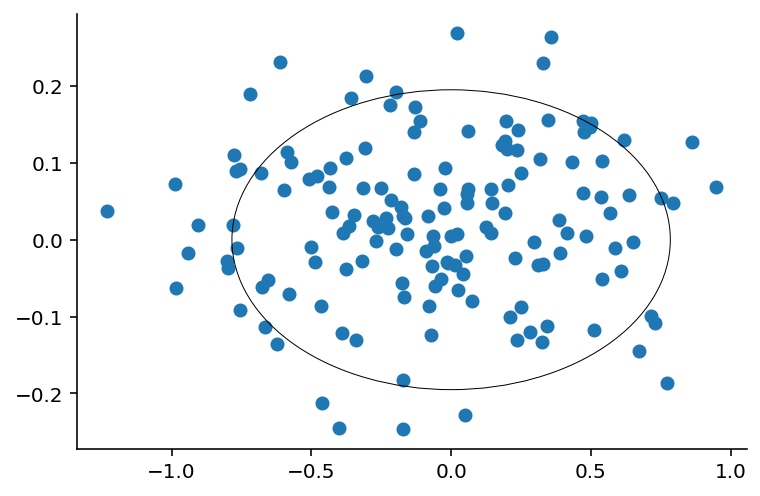

In [5]:
key = random.PRNGKey(314)
σx, σy = 0.4, 0.1
S = jnp.diagflat(jnp.array([σx, σy]) ** 2)
samples = random.multivariate_normal(key, jnp.zeros(2), S, (150,))
samples = samples[:, :2]

fig, ax = plt.subplots()
ax.scatter(*samples.T)
ellipse = Ellipse([0,0], width=2 * 1.96 * σx, height=2 * 1.95 * σy, fill=False, linewidth=0.5)
ax.add_patch(ellipse)

In [6]:
def plot_tracking_values(observed, filtered, cov_hist, ax):
    """
    observed: array(nsteps, 2)
        Array of observed values
    filtered: array(nsteps, state_size)
        Array of latent (hidden) values. We consider only the first
        two dimensions of the latent values
    cov_hist: array(nsteps, state_size, state_size)
        History of the retrieved (filtered) covariance matrices
    ax: matplotlib AxesSubplot
    """
    timesteps, _ = observed.shape
    ax.plot(observed[:, 0], observed[:, 1], marker="o", linewidth=0,
             markerfacecolor="none", markeredgewidth=2, markersize=8, label="observed", c="tab:green")
    ax.plot(*filtered[:, :2].T, label="filtered", c="tab:red", marker="x", linewidth=2)
    for t in range(0, timesteps, 1):
        covn = cov_hist[t][:2, :2]
        # Eigenvalues correspond to entries in the diagonal
        # of a diagonal matrix
        σx, σy = jnp.sqrt(jnp.diag(covn[:2, :2]))
        # width and heighta are twice the distance from the mean to the 1.96σx (95% confidence)
        # perpendicular distance
        zscore = 1.96
        width = 2 * zscore * σx
        height = 2 * zscore * σy
        ellipse = Ellipse(filtered[t, :2], width, height, fill=False, linewidth=0.8)
        ax.add_patch(ellipse)
    ax.axis("equal")
    ax.legend()

In [7]:
def lds_sample(A, C, Q, R, μ0, Σ0=0, timesteps=15, random_state=314):
    """
    Simulate a run of (switching) stochastic linear dynamical systems

    Parameters
    ----------
    A: array(state_size, state_size)
        Transition matrix
    C: array(observation_size, state_size)
        Observation matrix
    Q: array(state_size, state_size)
        Transition covariance matrix
    R: array(observation_size, observation_size)
        Observation covariance
    μ0: array(state_size)
        Mean of initial configuration
    Σ0: array(state_size, state_size) or 0
        Covariance of initial configuration. If value is set
        to zero, the initial state will be completely determined
        by μ0
    timesteps: int
        Total number of steps to sample
    random_state: int
        Seed of initial random states
        
    Returns
    -------
    * array(timesteps, state_size):
        Latent-state simulations
    * array(observation_size, timesteps):
        Simulations of latent and observed states
    """
    key = random.PRNGKey(random_state)
    state_size, _ = A.shape
    observation_size, _ = C.shape

    key_z1, key_eps, key_delta = random.split(key, 3)
    if Σ0 == 0:
        z1 = μ0
    else:
        z1 = random.multivariate_normal(key_z1, μ0, Σ0)

    # Generate all future noise terms
    eps = random.multivariate_normal(key_eps, jnp.zeros(state_size), Q, (timesteps, ))
    delta = random.multivariate_normal(key_delta, jnp.zeros(observation_size), R, (timesteps, ))
    
    z_hist = jnp.zeros((timesteps, state_size))
    x_hist = jnp.zeros((timesteps, observation_size))

    z_hist = index_update(z_hist, 0, z1)
    x_hist = index_update(x_hist, 0, C @ z1 + delta[0])
    for t in range(1, timesteps):
        zt = A @ z_hist[t-1] + eps[t]
        xt = C @ zt + delta[t]

        z_hist = index_update(z_hist, t, zt)
        x_hist = index_update(x_hist, t, xt)
        
    return z_hist, x_hist

In [8]:
timesteps = 15
Δ = 1
A = jnp.array([
    [1, 0, Δ, 0],
    [0, 1, 0, Δ],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

C = jnp.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

state_size, _ = A.shape
observation_size, _ = C.shape

Q = jnp.eye(state_size) * 0.001
R = jnp.eye(observation_size) * 1.0
# Prior parameter distribution
μ0 = jnp.array([10, 10, 1, 0])
Σ0 = jnp.eye(state_size) * 1.0

z_hist, x_hist = lds_sample(A, C, Q, R, μ0, Σ0=0, timesteps=timesteps, random_state=314)

### filename: `Kalman_tracking_truth.png`

(9.24486608505249, 25.857812213897706, 8.0420747756958, 11.636079216003418)

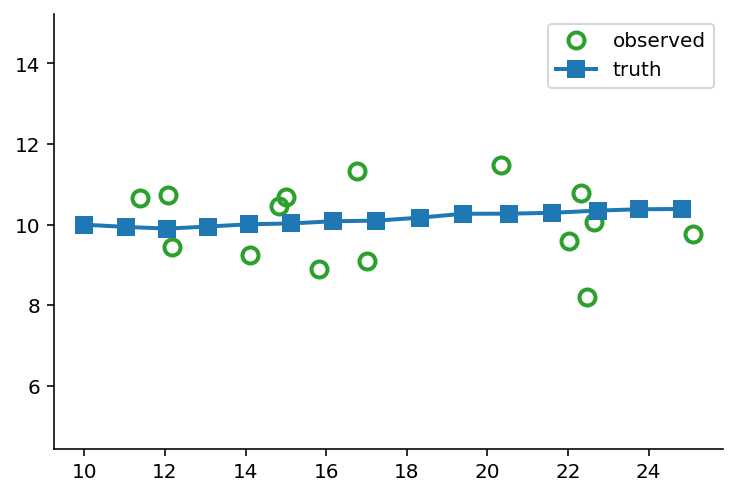

In [9]:
fig, ax = plt.subplots()

ax.plot(x_hist[:, 0], x_hist[:, 1], marker="o", linewidth=0,
         markerfacecolor="none", markeredgewidth=2, markersize=8, label="observed", c="tab:green")
ax.plot(z_hist[:, 0], z_hist[:, 1], linewidth=2, label="truth", marker="s", markersize=8)
ax.legend()
ax.axis("equal")

## Online-Kalman Filter

In [10]:
def kalman_filter(x_hist, A, C, Q, R, μ0, Σ0):
    """
    Compute the online version of the Kalman-Filter, i.e,
    the one-step-ahead prediction for the hidden state or the
    time update step
    
    Parameters
    ----------
    x_hist: array(timesteps, observation_size)
    A: array(state_size, state_size)
        Transition matrix
    C: array(observation_size, state_size)
        Observation matrix
    Q: array(state_size, state_size)
        Transition covariance matrix
    R: array(observation_size, observation_size)
        Observation covariance
    μ0: array(state_size)
        Mean of initial configuration
    Σ0: array(state_size, state_size) or 0
        Covariance of initial configuration. If value is set
        to zero, the initial state will be completely determined
        by μ0
        
    Returns
    -------
    * array(timesteps, state_size):
        Filtered means μt
    * array(timesteps, state_size, state_size)
        Filtered covariances Σt
    * array(timesteps, state_size)
        Filtered conditional means μt|t-1
    * array(timesteps, state_size, state_size)
        Filtered conditional covariances Σt|t-1
    """
    timesteps, _ = x_hist.shape
    state_size, _ = A.shape
    
    I = jnp.eye(state_size)
    μ_hist = jnp.zeros((timesteps, state_size))
    Σ_hist = jnp.zeros((timesteps, state_size, state_size))
    Σ_cond_hist = jnp.zeros((timesteps, state_size, state_size))
    μ_cond_hist = jnp.zeros((timesteps, state_size))
    
    # Initial configuration
    K1 = Σ0 @ C.T @ inv(C @ Σ0 @ C.T + R)
    μ1 = μ0 + K1 @ (x_hist[0] - C @ μ0)
    Σ1 = (I - K1 @ C) @ Σ0
    # Store initial values
    μ_hist = index_update(μ_hist, 0, μ1)
    Σ_hist = index_update(Σ_hist, 0, Σ1)
    μ_cond_hist = index_update(μ_cond_hist, 0, μ0)
    Σ_cond_hist = index_update(Σ_hist, 0, Σ0)
    
    Σn = Σ1
    for n in range(1, timesteps):
        # Σn|{n-1}
        Σn_cond = A @ Σn @ A.T + Q
        St = C @ Σn_cond @ C.T + R
        Kn = Σn_cond @ C.T @ inv(St)

        # μn|{n-1} and xn|{n-1}
        μ_update = A @ μ_hist[n-1]
        x_update = C @ μ_update

        μn = μ_update + Kn @ (x_hist[n] - x_update)
        Σn = (I - Kn @ C) @ Σn_cond

        μ_hist = index_update(μ_hist, n, μn)
        Σ_hist = index_update(Σ_hist, n, Σn)
        μ_cond_hist = index_update(μ_cond_hist, n, μ_update)
        Σ_cond_hist = index_update(Σ_cond_hist, n, Σn_cond)
    
    return μ_hist, Σ_hist, μ_cond_hist, Σ_cond_hist

In [11]:
μ_hist, Σ_hist, μ_cond_hist, Σ_cond_hist = kalman_filter(x_hist, A, C, Q, R, μ0, Σ0)

### filename: `Kalman_tracking_filtered.png`

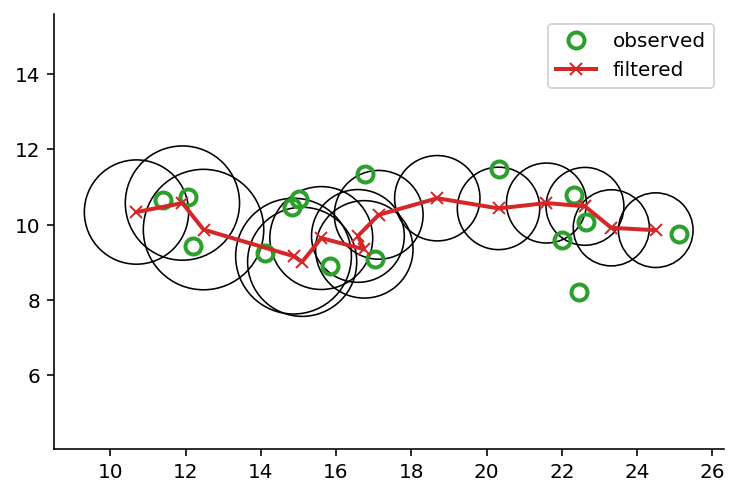

In [12]:
fig, ax = plt.subplots()
plot_tracking_values(x_hist, μ_hist, Σ_hist, ax)

## Kalman Smoother

In [13]:
def kalman_smoother(μ_hist, Σ_hist, μ_cond_hist, Σ_cond_hist, A):
    """
    Compute the offline version of the Kalman-Filter, i.e,
    the kalman smoother for the hidden state.
    Note that we require to independently run the kalman_filter function first
    
    Parameters
    ----------
    μ_hist: array(timesteps, state_size):
        Filtered means μt
    Σ_hist: array(timesteps, state_size, state_size)
        Filtered covariances Σt
    μ_cond_hist: array(timesteps, state_size)
        Filtered conditional means μt|t-1
    Σ_cond_hist: array(timesteps, state_size, state_size)
        Filtered conditional covariances Σt|t-1
    A: array(state_size, state_size)
        Transition matrix
        
    Returns
    -------
    * array(timesteps, state_size):
        Smoothed means μt
    * array(timesteps, state_size, state_size)
        Smoothed covariances Σt
    """
    timesteps, _ = μ_hist.shape
    state_size, _ = A.shape
    μ_hist_smooth = jnp.zeros((timesteps, state_size))
    Σ_hist_smooth = jnp.zeros((timesteps, state_size, state_size))

    μt_giv_T = μ_hist[-1, :]
    Σt_giv_T = Σ_hist[-1, :]

    # Update last step
    μ_hist_smooth = index_update(μ_hist_smooth, -1,  μt_giv_T)
    Σ_hist_smooth = index_update(Σ_hist_smooth, -1,  Σt_giv_T)

    elements = zip(μ_hist[-2::-1], Σ_hist[-2::-1, ...], μ_cond_hist[::-1, ...], Σ_cond_hist[::-1, ...])
    for t, (μtt, Σtt, μt_cond_next, Σt_cond_next) in enumerate(elements, 1):
        Jt  = Σtt @ A.T @ inv(Σt_cond_next)
        μt_giv_T = μtt + Jt @ (μt_giv_T - μt_cond_next)
        Σt_giv_T = Σtt + Jt @ (Σt_giv_T - Σt_cond_next) @ Jt.T
        
        μ_hist_smooth = index_update(μ_hist_smooth, -(t+1),  μt_giv_T)
        Σ_hist_smooth = index_update(Σ_hist_smooth, -(t+1), Σt_giv_T)
    
    return μ_hist_smooth, Σ_hist_smooth

In [14]:
μ_hist_smooth, Σ_hist_smooth = kalman_smoother(μ_hist, Σ_hist, μ_cond_hist, Σ_cond_hist, A)

### filename: `Kalman_tracking_smoothed.png`

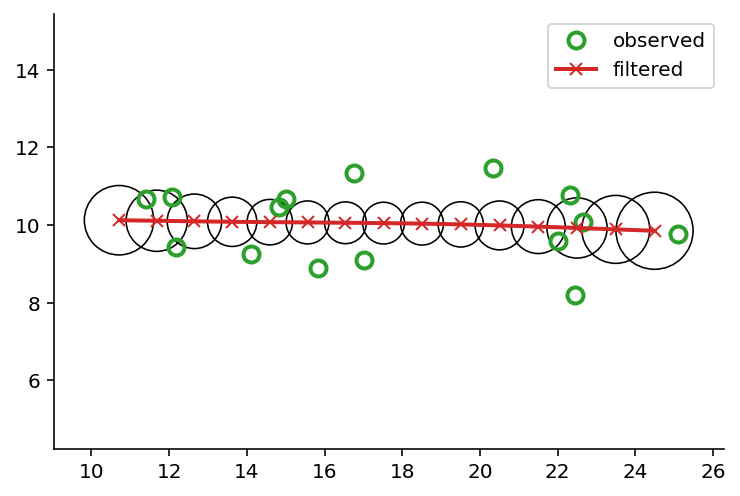

In [15]:
fig, ax = plt.subplots()
plot_tracking_values(x_hist, μ_hist_smooth, Σ_hist_smooth, ax)

# All together

In [16]:
timesteps = 15
Δ = 1
A = jnp.array([
    [1, 0, Δ, 0],
    [0, 1, 0, Δ],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

C = jnp.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

state_size, _ = A.shape
observation_size, _ = C.shape

Q = jnp.eye(state_size) * 0.001
R = jnp.eye(observation_size) * 1.0
# Prior parameter distribution
μ0 = jnp.array([10, 10, 1, 0])
Σ0 = jnp.eye(state_size) * 1.0

z_hist, x_hist = lds_sample(A, C, Q, R, μ0, Σ0=0, timesteps=timesteps, random_state=314)
μ_hist, Σ_hist, μ_cond_hist, Σ_cond_hist = kalman_filter(x_hist, A, C, Q, R, μ0, Σ0)
μ_hist_smooth, Σ_hist_smooth = kalman_smoother(μ_hist, Σ_hist, μ_cond_hist, Σ_cond_hist, A)

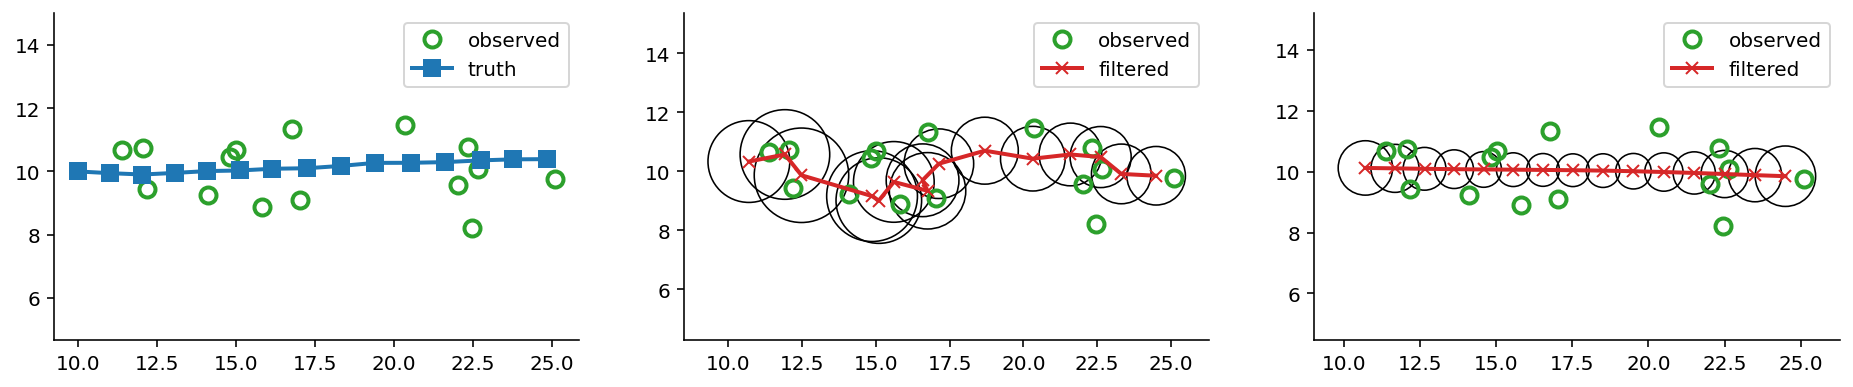

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(16, 3))

ax[0].plot(x_hist[:, 0], x_hist[:, 1], marker="o", linewidth=0,
         markerfacecolor="none", markeredgewidth=2, markersize=8, label="observed", c="tab:green")
ax[0].plot(z_hist[:, 0], z_hist[:, 1], linewidth=2, label="truth", marker="s", markersize=8)
ax[0].legend()
ax[0].axis("equal")

plot_tracking_values(x_hist, μ_hist, Σ_hist, ax[1])
plot_tracking_values(x_hist, μ_hist_smooth, Σ_hist_smooth, ax[2])

### References

* [Matplotlib references](https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html)